In [1]:
import numpy as np
from sklearn.semi_supervised import *
import os
import pandas as pd
from skimage.io import imread
from sklearn.metrics import classification_report
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.applications import MobileNetV2
import itertools


In [2]:
def prepareDataNN(df):
    data = []
    labels = []
    df_filtered = pd.DataFrame(columns=["patch_filename", "plastic"])
    patches_path = '/home/giorgia/Desktop/MAI/Thesis/images/patches/'
    for i in range(len(df)):
        patch_filename = os.path.join(patches_path, os.path.basename(df.loc[i, 'patch_filename']))
        im = imread(patch_filename)
        if im.shape == (256, 256, 3):
            data.append(im)
            labels.append(np.array(df.loc[i, 'plastic']))
            df_filtered = df_filtered.append(pd.Series(data={"patch_filename":df.loc[i, 'patch_filename'], "plastic":df.loc[i, 'plastic']}), ignore_index=True)
    return data, labels, df_filtered

In [3]:
def prepareData(df):
    data = []
    labels = []
    patches_path = '/home/giorgia/Desktop/MAI/Thesis/images/patches/'
    for i in range(len(df)):
        patch_filename = os.path.join(patches_path, os.path.basename(df.loc[i, 'patch_filename']))
        #im = np.amax(imread(patch_filename), axis=2) # maximum intensity projection
        im = imread(patch_filename)
        if im.shape == (256, 256, 3):
            feat, _ = np.histogram(im, bins = 100)
            data.append(feat)
            labels.append(df.loc[i, 'plastic'])
    return data, labels

In [10]:
df = pd.read_csv('/home/giorgia/Desktop/MAI/Thesis/patch_info.csv')
_,_,df = prepareDataNN(df) # filter patches of size < 256 * 256

df_plastic = df[df.plastic==1].reset_index()
df_noplastic = df[df.plastic==0].reset_index()
df_unlabeled = df[df.plastic!=-1].reset_index()
len(df_plastic), len(df_noplastic)

(583, 575)

In [11]:
partition = .7
test_set = df.copy()
print(len(test_set))
training_set = test_set.sample(frac=partition)
test_set = pd.merge(test_set, training_set, indicator=True, how='outer').query('_merge=="left_only"').drop(['_merge'], axis=1).reset_index()
print(len(test_set))
#validation_set = test_set.sample(frac=.5)
#test_set = pd.merge(test_set, validation_set, indicator=True, how='outer').query('_merge=="left_only"').drop(['_merge','index'], axis=1).reset_index()
#print(len(test_set))


1158
347


In [12]:
def get_preditictions(model, test_data, test_labels):
    pred_prob = model.predict(np.array(test_data))
    pred_class = []
    for p in pred_prob:
        if p >= .5:
            pred_class.append(1)
        else:
            pred_class.append(0)
    print(classification_report(test_labels, pred_class))
    return (pred_prob, pred_class)

In [13]:
training_data, training_labels, _ = prepareDataNN(training_set.reset_index())
test_data, test_labels, _ = prepareDataNN(test_set)

In [14]:
# unlabeled
X, Y, _ = prepareDataNN(df_unlabeled)

# merge labeled and unlabeled datasets
training_data = training_data + X 
training_labels = training_labels + Y

In [15]:
data_augmentation = keras.Sequential(
    [ layers.RandomFlip("horizontal"),
      layers.RandomRotation(0.2),
      #layers.RandomTranslation(0.8, 0.5),
      #layers.RandomZoom(0.5),
      layers.RandomContrast(0.1),
    ]
)

2022-03-23 14:43:05.507628: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-03-23 14:43:05.507737: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (giorgia-PX60-6QE): /proc/driver/nvidia/version does not exist
2022-03-23 14:43:05.531309: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [16]:
# preprocess data 
inputs = keras.Input(shape = (256, 256, 3))
x = data_augmentation(inputs)
x = layers.Rescaling(1.0 / 255)(x)

# load pre-trained model and weights without last layer
x = MobileNetV2(weights='imagenet', include_top=False, input_shape=(256, 256, 3))(x)

# add layers on top
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.25)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)

# trained model 
tf_model_mobnet = keras.Model(inputs, outputs)
tf_model_mobnet.load_weights("ckpts/mobnetv2_20.h5")
tf_model_mobnet.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)

for layer in tf_model_mobnet.layers:
    print(layer.name)

input_1
sequential
rescaling
mobilenetv2_1.00_224
global_average_pooling2d
dropout
dense


In [17]:
final_layer = "global_average_pooling2d"
extractor = keras.Model(inputs=tf_model_mobnet.input,
                        outputs=tf_model_mobnet.get_layer(final_layer).output)
features = []
step = 300
for i in range(0, len(training_data), step):
    if i + step >= len(training_data):
        end = len(training_data)
    else: 
        end = i + step
    features.append(np.array(extractor(np.array(training_data[i:end]))))
features = np.array(list(itertools.chain(*features)))

2022-03-23 14:43:18.750882: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 1887436800 exceeds 10% of free system memory.
2022-03-23 14:43:19.002569: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 1887436800 exceeds 10% of free system memory.
2022-03-23 14:43:19.366399: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 1887436800 exceeds 10% of free system memory.
2022-03-23 14:43:19.676463: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 1917043200 exceeds 10% of free system memory.
2022-03-23 14:43:25.801717: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 1887436800 exceeds 10% of free system memory.


In [147]:
label_prop_model = LabelPropagation()
label_prop_model.fit(features, training_labels)
print(classification_report(test_labels,  label_prop_model.predict(extractor(np.array(test_data)))))

/home/giorgia/Desktop/MAI/Thesis/litter_env/lib/python3.8/site-packages/sklearn/semi_supervised/_label_propagation.py:316: ConvergenceWarning: max_iter=1000 was reached without convergence.
  warnings.warn(


In [28]:
from sklearn.ensemble import RandomForestClassifier 
rf = RandomForestClassifier(n_estimators=10, max_features=100)

In [29]:
features_test = np.array(extractor(np.array(test_data)))
self_training_model = SelfTrainingClassifier(base_estimator=rf)
self_training_model.fit(features, training_labels)
print(classification_report(test_labels,  self_training_model.predict(features_test)))

              precision    recall  f1-score   support

         0.0       0.76      0.81      0.78       175
         1.0       0.79      0.74      0.76       172

    accuracy                           0.77       347
   macro avg       0.77      0.77      0.77       347
weighted avg       0.77      0.77      0.77       347



In [30]:
pred_probs_rfmobnet = self_training_model.predict_proba(features_test)[:, 1]
pred_probs_mobnet, _ = get_preditictions(tf_model_mobnet, test_data, test_labels)

              precision    recall  f1-score   support

         0.0       0.78      0.80      0.79       175
         1.0       0.79      0.77      0.78       172

    accuracy                           0.78       347
   macro avg       0.78      0.78      0.78       347
weighted avg       0.78      0.78      0.78       347



/home/giorgia/Desktop/MAI/Thesis/litter_env/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/giorgia/Desktop/MAI/Thesis/litter_env/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


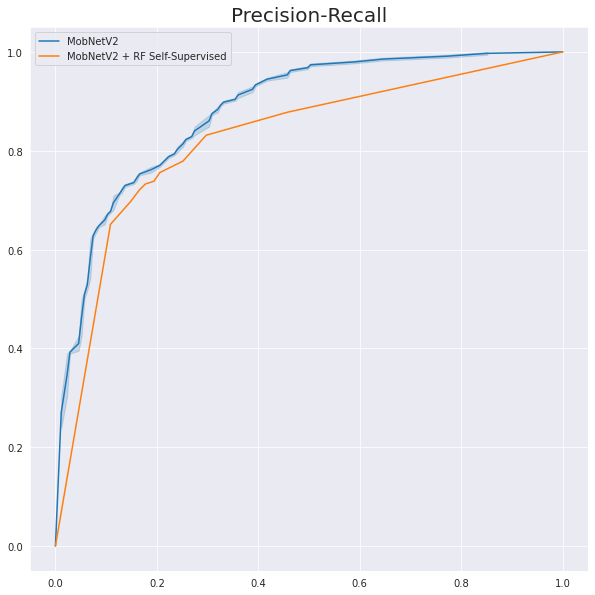

In [31]:
import matplotlib.pyplot as plt 
from sklearn.metrics import roc_curve

import seaborn as sns 

plt.figure(figsize=(10,10))
plt.title("Precision-Recall", fontsize=20)

# SVM
fpr, tpr, thresholds = roc_curve(test_labels, pred_probs_mobnet)
sns.lineplot(fpr, tpr, label="MobNetV2")

# RF
fpr, tpr, thresholds = roc_curve(test_labels, pred_probs_rfmobnet)
sns.lineplot(fpr, tpr, label="MobNetV2 + RF Self-Supervised")

sns.set_style("darkgrid")
plt.legend()

In [ ]:
xenia.ivashkovych@vito.be